<a href="https://colab.research.google.com/github/tumanov-a/home_bro/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from math import ceil

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import os

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [11]:
!pip install split-folders

In [12]:
import splitfolders

In [13]:
home_dir = '../content/drive/MyDrive/homebro'

for main_dir in os.listdir(home_dir):
        directory = os.path.join(home_dir, main_dir)
        for k, img_url in enumerate(os.listdir(directory)):
            img_url = os.path.join(directory, img_url)
            if k > 868:
                os.remove(img_url)

In [14]:
image_labels = os.listdir(home_dir)

In [15]:
splitfolders.ratio(home_dir, output='/content/sample_data', seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 4345 files [00:17, 249.06 files/s]


In [16]:
dirs = os.listdir('/content/sample_data/')
shapes = dict()
for dir in ['test', 'train', 'val']:
  dir_1 = os.path.join('/content/sample_data/', dir)
  len_path = 0
  if os.path.isdir(dir_1):
    for dir_2 in os.listdir(dir_1):
      len_path += len(os.listdir(os.path.join(dir_1, dir_2)))
    shapes[dir] = len_path

In [17]:
train_size = shapes['train']
val_size = shapes['val']
test_size = shapes['test']

In [18]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    )

In [19]:
train_dir = os.path.join('/content/sample_data/', 'train')
test_dir = os.path.join('/content/sample_data/', 'test')
val_dir = os.path.join('/content/sample_data/', 'val')

In [20]:
BATCH_SIZE = 32
INPUT_SIZE = 224

In [21]:
train_data_gen = image_gen.flow_from_directory(directory=train_dir, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=(INPUT_SIZE, INPUT_SIZE), 
                                               class_mode='categorical')

val_data_gen = image_gen.flow_from_directory(directory=val_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(directory=test_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical',
                                              shuffle=False)

Found 3040 images belonging to 5 classes.
Found 650 images belonging to 5 classes.
Found 655 images belonging to 5 classes.


In [22]:
classifier_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

feature_extractor = tf.keras.Sequential([
                                         hub.KerasLayer(classifier_url, input_shape=(INPUT_SIZE,INPUT_SIZE,3))
])

feature_extractor.trainable = False

model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [23]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_gen, 
    steps_per_epoch=ceil(train_size/BATCH_SIZE), 
    epochs=30, 
    validation_data=val_data_gen, 
    validation_steps=ceil(val_size/BATCH_SIZE),
    callbacks=[early_stopping]
    )

Epoch 1/30
95/95 [==============================] - 52s 547ms/step - loss: 0.2143 - accuracy: 0.9444 - val_loss: 0.0795 - val_accuracy: 0.9708
Epoch 2/30
95/95 [==============================] - 51s 535ms/step - loss: 0.0549 - accuracy: 0.9832 - val_loss: 0.0673 - val_accuracy: 0.9754
Epoch 3/30
95/95 [==============================] - 51s 532ms/step - loss: 0.0491 - accuracy: 0.9832 - val_loss: 0.0855 - val_accuracy: 0.9738
Epoch 4/30
95/95 [==============================] - 53s 561ms/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.0870 - val_accuracy: 0.9769
Epoch 5/30
95/95 [==============================] - 54s 570ms/step - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0846 - val_accuracy: 0.9815
Epoch 6/30
95/95 [==============================] - 51s 540ms/step - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.0665 - val_accuracy: 0.9846
Epoch 7/30
95/95 [==============================] - 51s 536ms/step - loss: 0.0195 - accuracy: 0.9934 - val_loss: 0.1347 - val_accuracy: 0.9754

In [24]:
history = model.history

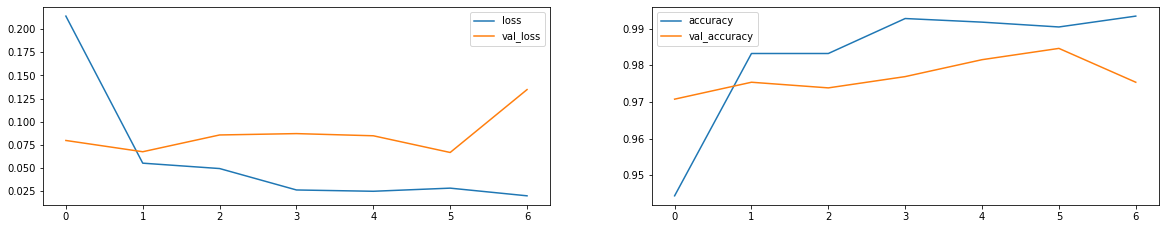

In [25]:
plt.figure(figsize=(20,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

In [26]:
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=ceil(test_size/BATCH_SIZE))

21/21 [==============================] - 9s 407ms/step - loss: 0.1003 - accuracy: 0.9740


In [27]:
test_labels = test_data_gen.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [28]:
predict_prob = model.predict(test_data_gen, steps=ceil(test_size/BATCH_SIZE))
predictions = predict_prob.argmax(axis=-1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [30]:
print(classification_report(test_labels, predictions, target_names=image_labels))

              precision    recall  f1-score   support

   buildings       0.97      0.98      0.97       131
    entrance       1.00      0.98      0.99       131
  flat_plans       1.00      1.00      1.00       131
    interior       0.96      0.95      0.96       131
     windows       0.94      0.96      0.95       131

    accuracy                           0.97       655
   macro avg       0.97      0.97      0.97       655
weighted avg       0.97      0.97      0.97       655



In [31]:
test_data_gen[0][1][2].argmax(axis=0)

0

In [32]:
import random

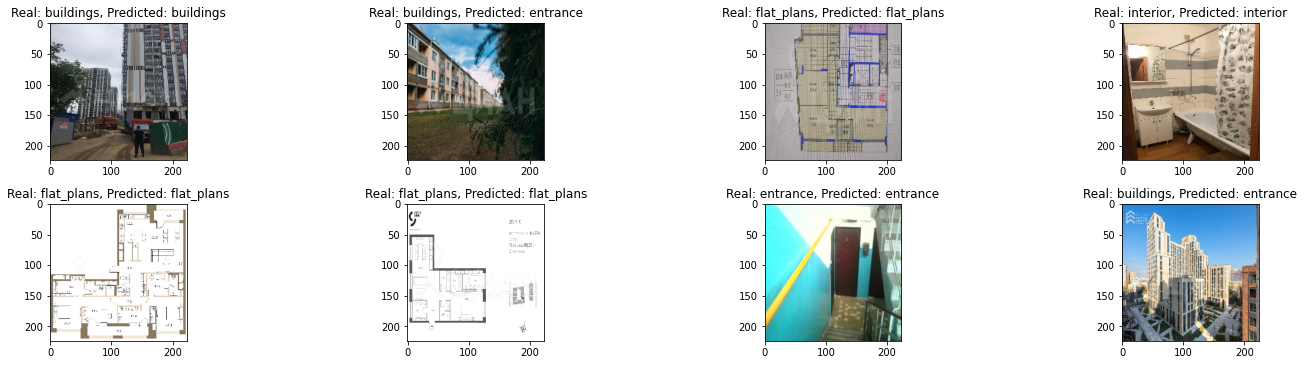

In [33]:
plt.figure(figsize=(20,20))

for i in range(8):

    index_batch = random.randint(0, 15)
    index_img = random.randint(0, 15)

    index_label_real = test_data_gen[index_batch][1][index_img].argmax(axis=0)
    img = test_data_gen[index_batch][0][index_img]

    plt.subplot(8, 4, i+1)
    plt.imshow(img)
    index_predicted_label = predictions[BATCH_SIZE * (index_batch + 1) + index_img]

    plt.title('Real: {}, Predicted: {}'.format(list(image_labels)[index_label_real], list(image_labels)[index_predicted_label]))

plt.tight_layout()

In [34]:
export_dir = 'saved_model'
tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [35]:
def load_and_preprocessing(img_path):
  img_raw = tf.io.read_file(img_path)
  img_tensor = tf.image.decode_image(img_raw)
  img_final = tf.image.resize(img_tensor, (INPUT_SIZE, INPUT_SIZE)) / 255
  img_final = np.expand_dims(img_final, axis=0)
  return img_final

In [54]:
img_path = '/content/sample_data/new_test/бабушкин ремонт люкс.jpg'
img = load_and_preprocessing(img_path)

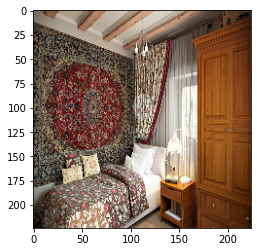

In [55]:
plt.imshow(img[0])

In [56]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index'] 
interpreter.set_tensor(input_index, img)
interpreter.invoke()
image_labels[interpreter.get_tensor(output_index).argmax(axis=1)[0]]

'entrance'